### CLASSIFICAZIONE TESTUALE

### Importazione delle librerie

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras import preprocessing
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization


### Importazione del datset

In [50]:
#IMPORTAZIONE DEL CSV
df = pd.read_csv('/content/Emotion_classify_Data.csv')
print(df.head())

                                             Comment Emotion
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear


### Eseguiamo i classici controlli di routine

In [51]:
#VISUALIZZIAMO LE COLONNE
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


non ci sono valori nulli

In [52]:
df.describe()

,Comment,Emotion
count,5937,5937
unique,5934,3
top,i feel pretty tortured because i work a job an...,anger
freq,2,2000


Vediamo quante label ci sono, ma vediamo anche che 3 commenti vengono ripetuti, ciò ci porta a condurre un'analisi approfondita: vogliamo vedere se stessi commenti sono classificati come diverse emozioni ed eliminarli in caso

In [53]:
print("Numero di righe duplicate:", df.duplicated().sum())

Numero di righe duplicate: 0


In [54]:
duplicate_comments = df[df.duplicated(subset='Comment', keep=False)]
duplicated_comments_different_emotion = duplicate_comments.groupby('Comment')['Emotion'].unique()
comments_with_different_emotions = duplicated_comments_different_emotion[duplicated_comments_different_emotion.apply(lambda x: len(x) > 1)].index
if len(comments_with_different_emotions) > 0:
    print("\nCommenti duplicati con emozioni diverse:")
    for comment in comments_with_different_emotions:
        print(f"Commento: {comment}")
        print(df[df['Comment'] == comment])
else:
    print("\nNon ci sono commenti duplicati con emozioni diverse.")


Commenti duplicati con emozioni diverse:
Commento: i feel like a tortured artist when i talk to her
                                               Comment Emotion
2262  i feel like a tortured artist when i talk to her   anger
5870  i feel like a tortured artist when i talk to her    fear
Commento: i feel pretty tortured because i work a job and often the inspiration strikes while im at work
                                                Comment Emotion
2877  i feel pretty tortured because i work a job an...   anger
4869  i feel pretty tortured because i work a job an...    fear
Commento: i resorted to yesterday the post peak day of illness when i was still housebound but feeling agitated and peckish for brew a href http pics
                                                Comment Emotion
986   i resorted to yesterday the post peak day of i...   anger
1930  i resorted to yesterday the post peak day of i...    fear


Questi sono i commenti duplicati, che vengono classificati con emozioni diverse. Vediamo che sono esattamente 6, come ci si aspettava.

In [55]:
rows_to_drop = df[df['Comment'].isin(comments_with_different_emotions)].index
df.drop(rows_to_drop, inplace=True)
print(f"Numero di righe rimosse a causa di commenti duplicati con emozioni diverse: {len(rows_to_drop)}")
duplicate_comments_after_drop = df[df.duplicated(subset='Comment', keep=False)]
duplicated_comments_different_emotion_after_drop = duplicate_comments_after_drop.groupby('Comment')['Emotion'].unique()
comments_with_different_emotions_after_drop = duplicated_comments_different_emotion_after_drop[duplicated_comments_different_emotion_after_drop.apply(lambda x: len(x) > 1)].index
if len(comments_with_different_emotions_after_drop) > 0:
    print("\nCommenti duplicati con emozioni diverse rimasti (dopo la rimozione):")
    for comment in comments_with_different_emotions_after_drop:
        print(f"Commento: {comment}")
        print(df[df['Comment'] == comment])
else:
    print("\nNon ci sono più commenti duplicati con emozioni diverse.")

Numero di righe rimosse a causa di commenti duplicati con emozioni diverse: 6

Non ci sono più commenti duplicati con emozioni diverse.


Poichè le emozioni sono diverse, procediamo alla cancellazione delle righe discusse

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5931 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5931 non-null   object
 1   Emotion  5931 non-null   object
dtypes: object(2)
memory usage: 139.0+ KB


Conferma della cancellazione delle sei righe incriminate:5931 non nulli

<ipython-input-57-572188164>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


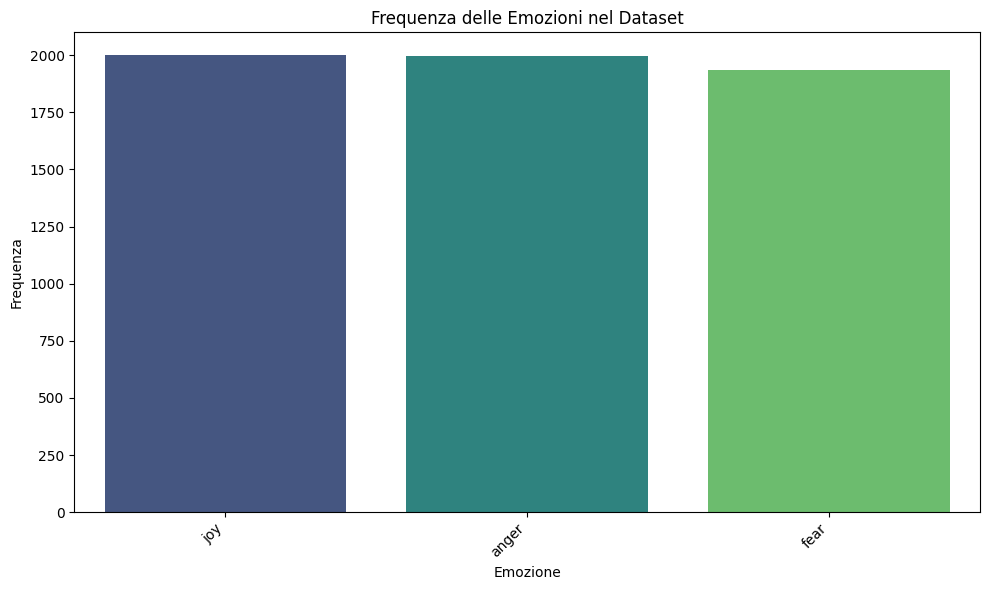

In [57]:
emotion_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Frequenza delle Emozioni nel Dataset')
plt.xlabel('Emozione')
plt.ylabel('Frequenza')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

L'istogramma delle frequenze ha lo scopo di valutare la distribuzione delle classi nella variabile target, per eventualmente mantenere le proporzioni invariate durante la fase di split del dataset in train e test.

### Preprocessing

### Rimozione delle stop words

In [58]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
if 'Comment' in df.columns:
    df['text_without_stopwords'] = df['Comment'].apply(remove_stopwords)
    print(df[['Comment', 'text_without_stopwords']].head())
else:
    print("DataFrame does not have a 'text' column. Please adjust the column name if necessary.")


                                             Comment  \
0  i seriously hate one subject to death but now ...   
1                 im so full of life i feel appalled   
2  i sit here to write i start to dig out my feel...   
3  ive been really angry with r and i feel like a...   
4  i feel suspicious if there is no one outside l...   

                              text_without_stopwords  
0  seriously hate one subject death feel reluctan...  
1                         im full life feel appalled  
2  sit write start dig feelings think afraid acce...  
3  ive really angry r feel like idiot trusting fi...  
4  feel suspicious one outside like rapture happe...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La rimozione delle stop words avviene prima della tokenizzazione, che è un filtro sulle parole più frequenti, che possono essere anche stopwords.

### Tokenizzazione

In [59]:
tokenizer = Tokenizer(num_words=1000)   # Crea un tokenizer, configurato per tenere
                                        # in considerazione solo le 10000 parole più comuni
tokenizer.fit_on_texts(df['Comment'])
sequences = tokenizer.texts_to_sequences(df['Comment'])
sequences

[[1, 650, 263, 73, 4, 962, 18, 58, 1, 2, 225, 4, 12],
 [14, 15, 500, 9, 88, 1, 2, 963],
 [1,
  444,
  144,
  4,
  195,
  1,
  215,
  4,
  50,
  10,
  134,
  3,
  1,
  70,
  8,
  1,
  19,
  177,
  4,
  964,
  5,
  8,
  67,
  237,
  26,
  87,
  12],
 [77, 51, 47, 150, 23, 3, 1, 2, 13, 83, 20, 625, 74, 11, 5, 178, 238],
 [1, 2, 436, 43, 72, 25, 91, 73, 651, 13, 5, 101, 501, 34, 82],
 [1, 2, 287, 1, 288, 8, 181, 9, 102, 5, 693, 458, 270, 3, 1, 288, 8],
 [32, 6, 239, 9, 594, 912, 671, 16, 84, 8, 501, 4, 103],
 [1, 595, 7, 150, 3, 75, 500, 9, 759],
 [1, 2, 6, 68, 244, 3, 11, 6, 111, 78],
 [1, 2, 13, 1, 301, 258, 726, 240, 9, 10, 88, 114, 25, 469],
 [1, 2, 6, 68, 13, 11, 5, 26, 196, 56, 48, 12, 18, 5, 17, 6, 760],
 [1,
  17,
  7,
  33,
  5,
  215,
  146,
  55,
  4,
  549,
  92,
  33,
  37,
  17,
  47,
  437,
  4,
  550,
  21,
  95,
  5,
  438,
  9,
  445,
  1,
  63,
  175,
  50,
  5,
  241],
 [1, 17, 40, 6],
 [1,
  38,
  26,
  116,
  160,
  49,
  7,
  424,
  18,
  113,
  5,
  264,
  1,
  301,

In [60]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 8974 unique tokens.


{'i': 1,
 'feel': 2,
 'and': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'feeling': 7,
 'that': 8,
 'of': 9,
 'my': 10,
 'in': 11,
 'it': 12,
 'like': 13,
 'im': 14,
 'so': 15,
 'me': 16,
 'was': 17,
 'but': 18,
 'am': 19,
 'for': 20,
 'this': 21,
 'have': 22,
 'with': 23,
 'about': 24,
 'is': 25,
 'not': 26,
 'be': 27,
 'as': 28,
 'on': 29,
 'you': 30,
 'just': 31,
 'when': 32,
 'at': 33,
 'or': 34,
 'because': 35,
 'more': 36,
 'all': 37,
 'do': 38,
 'up': 39,
 'by': 40,
 'can': 41,
 't': 42,
 'if': 43,
 'very': 44,
 'are': 45,
 'little': 46,
 'really': 47,
 'know': 48,
 'myself': 49,
 'out': 50,
 'been': 51,
 'time': 52,
 'get': 53,
 'what': 54,
 'want': 55,
 'people': 56,
 'being': 57,
 'now': 58,
 'how': 59,
 'had': 60,
 'from': 61,
 'they': 62,
 'will': 63,
 'them': 64,
 'her': 65,
 'some': 66,
 'he': 67,
 'bit': 68,
 'would': 69,
 'think': 70,
 'even': 71,
 'there': 72,
 'one': 73,
 'him': 74,
 'still': 75,
 'who': 76,
 'ive': 77,
 'way': 78,
 'its': 79,
 'we': 80,
 'going': 81,
 'somethi

Riotteniamo l'indice delle parole.

### Label Encoding

In [61]:
label_encoder = LabelEncoder()
df['Emotion_encoded'] = label_encoder.fit_transform(df['Emotion'])
print(df[['Emotion', 'Emotion_encoded']].head())
print("Class labels and their encoded values:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")
labels =to_categorical(df['Emotion_encoded'])


  Emotion  Emotion_encoded
0    fear                1
1   anger                0
2    fear                1
3     joy                2
4    fear                1
Class labels and their encoded values:
anger: 0
fear: 1
joy: 2


Prima eseguiamo l'encoding usando label encoder che crea una nuova colonna chiamata Emotions_encoded che contiene interi, in seguito le label vengono convertite in vettori, cosa necessaria per l'utilizzo di "categorical_crossentropy".

### Creazione del layer di embedding

In [62]:
embedding_layer = Embedding(10000, 64) #noi prendiamo le 10000 parole più comuni, quindi il nostro vocabolario sarà composto da 10000 parole

Definiamo un layer di embadding, che sarà lo strato adibito a rendere le X dei vettori densi, per fare ciò necessita di conoscere in input la dimensione del dizionario che stiamo usando.

### Dividiamo il dataset in train e test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(sequences,labels, test_size=0.2, random_state=42)
print(f"Numero di sequenze di training: {len(X_train)}")
print(f"Numero di sequenze di test: {len(X_test)}")
print(f"Numero di label di training: {len(y_train)}")
print(f"Numero di label di test: {len(y_test)}")

Numero di sequenze di training: 4744
Numero di sequenze di test: 1187
Numero di label di training: 4744
Numero di label di test: 1187


Lo split agisce correttamente anche se sequences e labels non fanno parte dello stesso dataframe, questo perchè sono perfettamente ordinate.

### Padding delle sequenze

In [64]:
maxlen = 100  # Definisci la lunghezza massima delle sequenze
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print(f"Dimensione di X_train dopo il padding: {X_train.shape}")
print(f"Dimensione di X_test dopo il padding: {X_test.shape}")

Dimensione di X_train dopo il padding: (4744, 100)
Dimensione di X_test dopo il padding: (1187, 100)


Il padding serve per rendere omogenea la lunghezza delle sequenze, cosa necessaria per la loro elaborazione, impostiamo una lunghezza massima di 100.

### Modello 1

In [65]:
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - acc: 0.3314 - loss: 1.1026 - val_acc: 0.5068 - val_loss: 1.0847
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.6771 - loss: 1.0498 - val_acc: 0.6175 - val_loss: 1.0097
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.7871 - loss: 0.8960 - val_acc: 0.6870 - val_loss: 0.8644
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8510 - loss: 0.6865 - val_acc: 0.7503 - val_loss: 0.7109
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9101 - loss: 0.4745 - val_acc: 0.8008 - val_loss: 0.5792
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.9447 - loss: 0.3266 - val_acc: 0.8314 - val_loss: 0.4889
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9589 - loss: 0.2265 - val_acc: 0.8483 - val_loss: 0.4319
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.9718 - loss: 0.1599 - val_acc: 0.8620 - val_loss: 0.3902
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

Eseguiamo il plotting dei grafici di loss e accuracy per epoche.

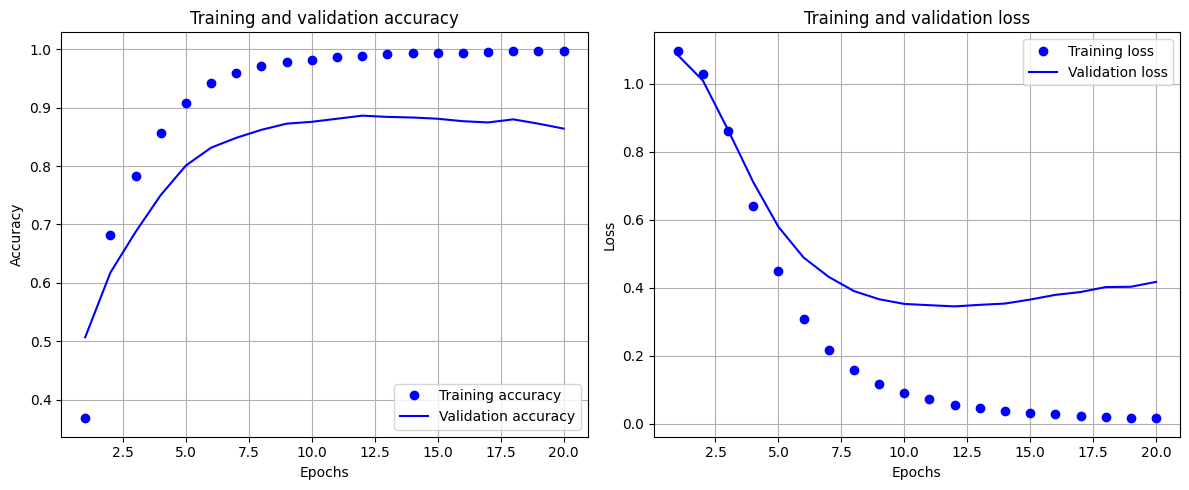

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Il modello ha problemi di overfitting immediato, anche se costante, già subito dalla seconda epoca, dovrà essere reso meno complicato per riuscire ad eseguire previsioni efficaci, indipendentemente dall'epoca che sceglieremo di impostare in fase di previsione.


### Modello 2: riduciamo l'output dello strato di embadding

In [68]:
embedding_layer2 = Embedding(10000, 16)

Ridurre l'output dello strato di embadding fa si che la rappresentazione dei vettori sia grossolana, con meno parametri, e che quindi riesca a ridurre l'overfitting, che troviamo ad ogni epoca.

In [69]:
model2 = Sequential()
model2.add(embedding_layer2)
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['acc'])
model2.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model2.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.3170 - loss: 1.1020 - val_acc: 0.3815 - val_loss: 1.0948
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.4564 - loss: 1.0853 - val_acc: 0.5258 - val_loss: 1.0757
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.6696 - loss: 1.0455 - val_acc: 0.5848 - val_loss: 1.0261
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7434 - loss: 0.9619 - val_acc: 0.6660 - val_loss: 0.9492
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8040 - loss: 0.8472 - val_acc: 0.7050 - val_loss: 0.8562
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8434 - loss: 0.7180 - val_acc: 0.7503 - val_loss: 0.7616
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8858 - loss: 0.5921 - val_acc: 0.7935 - val_loss: 0.6725
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9029 - loss: 0.4838 - val_acc: 0.8030 - val_loss: 0.5953
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - a

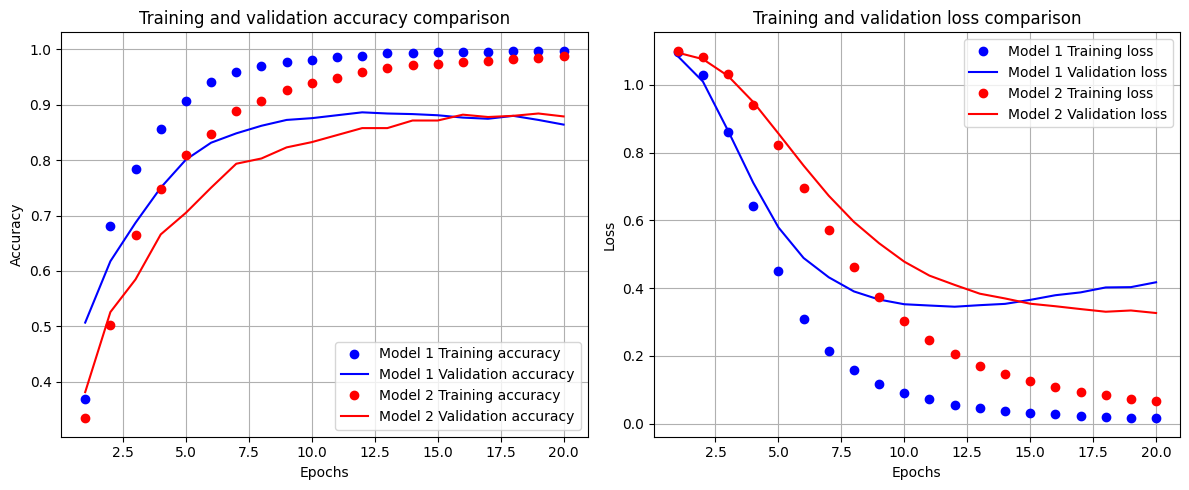

In [71]:
#istanziazione della figura
acc2 = history.history['acc']
val_acc2 = history.history['val_acc']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']
epochs2 = range(1, len(acc2) + 1)
plt.figure(figsize=(12, 5))
# Plotting dell'Accuracy per entrambi i modelli
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Model 1 Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Model 1 Validation accuracy')
plt.plot(epochs2, acc2, 'ro', label='Model 2 Training accuracy')
plt.plot(epochs2, val_acc2, 'r', label='Model 2 Validation accuracy')
plt.title('Training and validation accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
# Plotting della Loss per entrambi i modelli
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Model 1 Training loss')
plt.plot(epochs, val_loss, 'b', label='Model 1 Validation loss')
plt.plot(epochs2, loss2, 'ro', label='Model 2 Training loss')
plt.plot(epochs2, val_loss2, 'r', label='Model 2 Validation loss')
plt.title('Training and validation loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Nonostante il modello due sembri migliore, comunque il problema rimane: dopo la terza epoca circa il modello non lavora bene  sui dati di validazione (e alla terza epoca l'accuracy è a 70, direi che si può fare meglio!!)
Il modello va reso ancora meno complicato.

In [72]:
diff_acc_model1 = np.array(acc) - np.array(val_acc)
diff_acc_model2 = np.array(acc2) - np.array(val_acc2)
average_diff_model1 = np.mean(diff_acc_model1)
average_diff_model2 = np.mean(diff_acc_model2)
results_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 2'],
    'Average Train-Validation Accuracy Difference': [average_diff_model1, average_diff_model2]
})
print("\nTabella della differenza media (tra epoche) tra accuracy di training e validation:")
results_df


Tabella della differenza media (tra epoche) tra accuracy di training e validation:


,Model,Average Train-Validation Accuracy Difference
0,Model 1,0.096330
1,Model 2,0.086068


Effettivamente il modello due riduce tale differenza dopo un certo numero di epoche, ma in generale essa rimane ancora del 10 per cento, per ridurre l'overfitting ulteriormente modifichiamo la architettura del modello. Andiamo a valutare la differenza media cumulata sulle epoche delle due curve, per avere un idea di quanto si discostano. Valutiamo poi le stesse differenze medie per epoche passate.

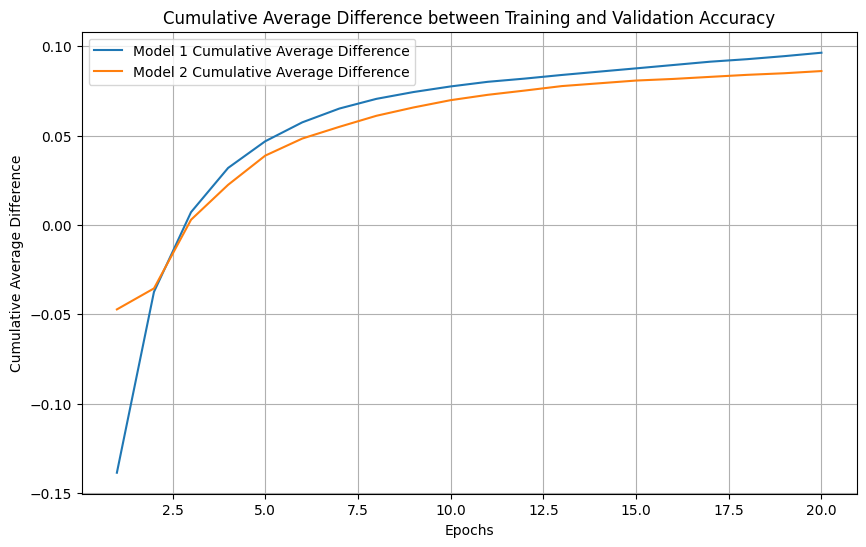


Tabella della differenza media cumulata (per ogni epoca) tra accuracy di training e validation:


,Epoch,Model 1 Cumulative Average Difference,Model 2 Cumulative Average Difference
0,1,-0.138733,-0.047330
1,2,-0.037533,-0.035585
2,3,0.007098,0.002854
3,4,0.031855,0.022408
4,5,0.046765,0.038728
5,6,0.057365,0.048292
6,7,0.065087,0.054862
7,8,0.070517,0.061041
8,9,0.074331,0.065701
9,10,0.077461,0.069772


In [73]:
diff_acc_model1_cumulative = np.cumsum(diff_acc_model1) / (np.arange(len(diff_acc_model1)) + 1)
diff_acc_model2_cumulative = np.cumsum(diff_acc_model2) / (np.arange(len(diff_acc_model2)) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, diff_acc_model1_cumulative, label='Model 1 Cumulative Average Difference')
plt.plot(epochs2, diff_acc_model2_cumulative, label='Model 2 Cumulative Average Difference')
plt.title('Cumulative Average Difference between Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Average Difference')
plt.legend()
plt.grid(True)
plt.show()
results_df_cumulative = pd.DataFrame({
    'Epoch': epochs,
    'Model 1 Cumulative Average Difference': diff_acc_model1_cumulative,
    'Model 2 Cumulative Average Difference': diff_acc_model2_cumulative
})
print("\nTabella della differenza media cumulata (per ogni epoca) tra accuracy di training e validation:")
results_df_cumulative


### Modello 3: modifica di batch size

Andiamo a modificare il batch size, ovvero il numero di campioni che il modello guarda prima di aggiornare i pesi, se aumentato, il modello apprede in maniera meno raffinata. In questo modo speriamo di ridurre ulteriormente l'overfitting immediato.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6828 - loss: 0.9985 - val_accuracy: 0.8778 - val_loss: 0.8105
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9640 - loss: 0.6810 - val_accuracy: 0.8799 - val_loss: 0.6137
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9673 - loss: 0.4652 - val_accuracy: 0.8830 - val_loss: 0.4857
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9695 - loss: 0.3173 - val_accuracy: 0.8872 - val_loss: 0.4112
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9700 - loss: 0.2341 - val_accuracy: 0.8851 - val_loss: 0.3674
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9759 - loss: 0.1776 - val_accuracy: 0.8820 - val_loss: 0.3405
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9742 - loss: 0.1501 - val_accuracy: 0.8883 - val_loss: 0.3231
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9819 - loss: 0.1161 - val_accuracy: 0.8872 - val_loss

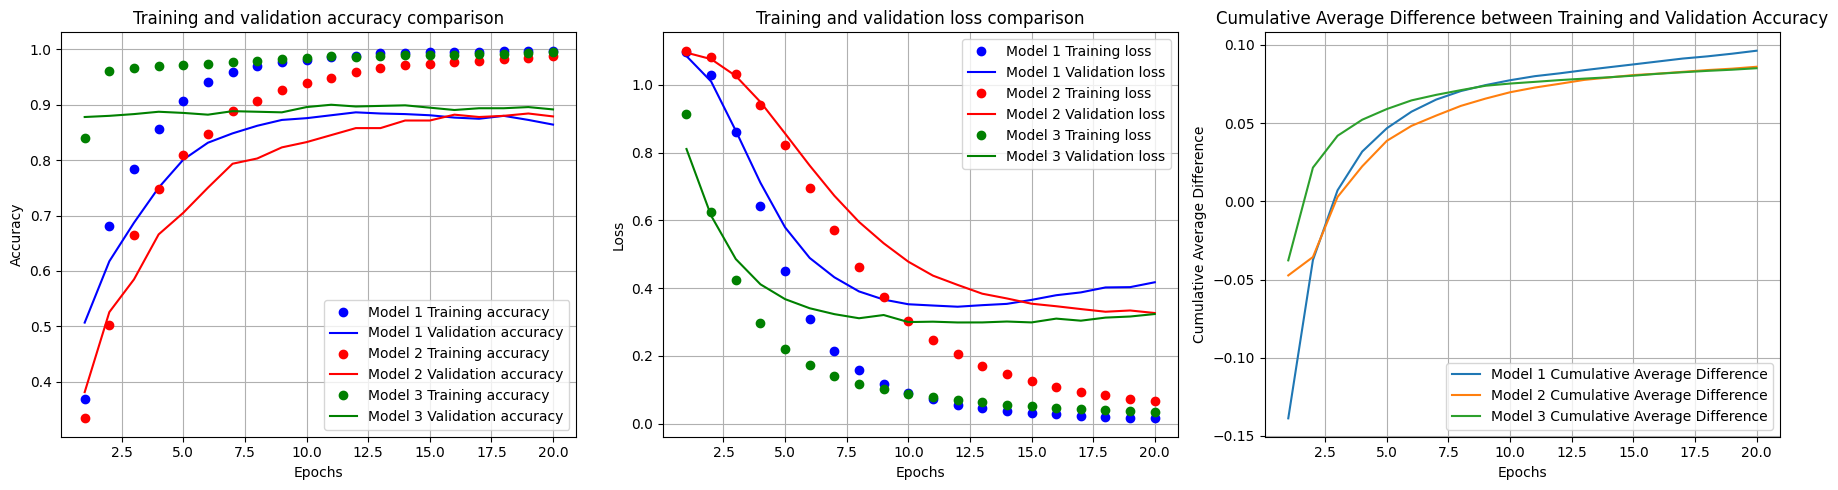


Tabella della differenza media cumulata (per ogni epoca) tra accuracy di training e validation per tutti i modelli:


,Epoch,Model 1 Cumulative Average Difference,Model 2 Cumulative Average Difference,Model 3 Cumulative Average Difference
0,1,-0.138733,-0.047330,-0.037713
1,2,-0.037533,-0.035585,0.021575
2,3,0.007098,0.002854,0.041954
3,4,0.031855,0.022408,0.052209
4,5,0.046765,0.038728,0.059047
5,6,0.057365,0.048292,0.064572
6,7,0.065087,0.054862,0.068104
7,8,0.070517,0.061041,0.071116
8,9,0.074331,0.065701,0.073926
9,10,0.077461,0.069772,0.075332


In [74]:
model3 = Sequential()
model3.add(embedding_layer2)
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model3.summary()
history3 = model3.fit(X_train, y_train,
                    epochs=20,
                    batch_size=45,  # Aumentato il batch size
                    validation_split=0.2)
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs3 = range(1, len(acc3) + 1)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'bo', label='Model 1 Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Model 1 Validation accuracy')
plt.plot(epochs2, acc2, 'ro', label='Model 2 Training accuracy')
plt.plot(epochs2, val_acc2, 'r', label='Model 2 Validation accuracy')
plt.plot(epochs3, acc3, 'go', label='Model 3 Training accuracy')
plt.plot(epochs3, val_acc3, 'g', label='Model 3 Validation accuracy')
plt.title('Training and validation accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'bo', label='Model 1 Training loss')
plt.plot(epochs, val_loss, 'b', label='Model 1 Validation loss')
plt.plot(epochs2, loss2, 'ro', label='Model 2 Training loss')
plt.plot(epochs2, val_loss2, 'r', label='Model 2 Validation loss')
plt.plot(epochs3, loss3, 'go', label='Model 3 Training loss')
plt.plot(epochs3, val_loss3, 'g', label='Model 3 Validation loss')
plt.title('Training and validation loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
diff_acc_model3_cumulative = np.cumsum(np.array(acc3) - np.array(val_acc3)) / (np.arange(len(acc3)) + 1)
plt.subplot(1, 3, 3)
plt.plot(epochs, diff_acc_model1_cumulative, label='Model 1 Cumulative Average Difference')
plt.plot(epochs2, diff_acc_model2_cumulative, label='Model 2 Cumulative Average Difference')
plt.plot(epochs3, diff_acc_model3_cumulative, label='Model 3 Cumulative Average Difference')
plt.title('Cumulative Average Difference between Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Average Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
results_df_cumulative_all = pd.DataFrame({
    'Epoch': epochs3,
    'Model 1 Cumulative Average Difference': diff_acc_model1_cumulative,
    'Model 2 Cumulative Average Difference': diff_acc_model2_cumulative,
    'Model 3 Cumulative Average Difference': diff_acc_model3_cumulative
})
print("\nTabella della differenza media cumulata (per ogni epoca) tra accuracy di training e validation per tutti i modelli:")
results_df_cumulative_all


Il modello 3 effettivamente riduce la differenza che c'è fra accuracy, ma quello che succede è che essa si satura subito. La modifica del batch size non è efficace in quanto essa porta a una minor numero di aggiornamenti dei pesi per ogni epoca e ciò fa si che l'accuracy nella fase di validation resti più o meno costante. Ritorniamo dunque ad una struttura del tipo Modello 2, cercando altri modi per ridurne la complessità.

### modello 4: modello con droupout, reduce learning rate, batch normalization (ed eventuamente early stopping)

In [75]:
reduce_lr = ReduceLROnPlateau(
    monitor='acc',
    factor=0.5,        # dimezza il learning rate
    patience=2,        # se non migliora per 2 epoche
    min_lr=1e-6,       # limite inferiore
    verbose=1
)
#earlychart = EarlyStopping(
   # monitor='val_acc',
   # patience=3,
    #verbose=1
#)


Abbiamo implementato un layer di batch normalization, uno strato di dropout, un callback che riduceva il LR in caso la accuracy non migliori per due epoche. Per il resto il modello 4 è uguale al modello 2.

In [76]:
learning_rate = 0.0005
model4 = Sequential()
model4.add(embedding_layer2)
model4.add(Flatten())
model4.add(BatchNormalization())
model4.add(Dropout(0.5)) # 50% di dropout
model4.add(Dense(3, activation='softmax'))
model4.compile(optimizer=Adam(learning_rate=learning_rate),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model4.summary()

history4 = model4.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[reduce_lr])
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
epochs4 = range(1, len(acc4) + 1)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4385 - loss: 1.2619 - val_accuracy: 0.8124 - val_loss: 0.8432 - learning_rate: 5.0000e-04
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7821 - loss: 0.6347 - val_accuracy: 0.8535 - val_loss: 0.5833 - learning_rate: 5.0000e-04
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8697 - loss: 0.4148 - val_accuracy: 0.8714 - val_loss: 0.4272 - learning_rate: 5.0000e-04
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9044 - loss: 0.3201 - val_accuracy: 0.8862 - val_loss: 0.3570 - learning_rate: 5.0000e-04
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9078 - loss: 0.2948 - val_accuracy: 0.8915 - val_loss: 0.3221 - learning_rate: 5.0000e-04
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9292 - loss: 0.2459 - val_accuracy: 0.8957 - val_loss: 0.3073 - learning_rate: 5.0000e-04
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9314 - loss: 0.2215 - val_accuracy: 0.8946 - val_loss: 0.3005 - learning_rate: 5.0000e-04
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9374 - 

Andiamo a visualizzare graficamente gli andamenti dei grafici di accuracy e loss

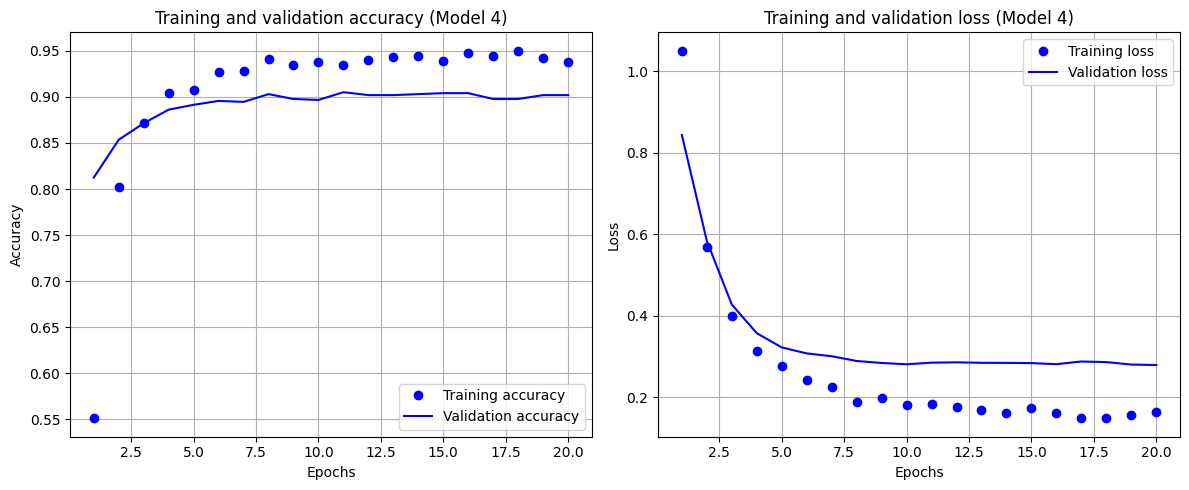

In [77]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs4, acc4, 'bo', label='Training accuracy')
plt.plot(epochs4, val_acc4, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs4, loss4, 'bo', label='Training loss')
plt.plot(epochs4, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In realtà la situazione non migliora quasi per nulla, rispetto al modello 3 la validation accuracy presenta un andamento leggermente crescente, ma tende ugualmente a saturarsi. In conclusione:
in conclusione:
*   modello uno: overfitting indipendente dal numero di epoche, ma accuracy non si stura subito.
*   modello due : overfitting stabile, accuracy in crescita nelle epoche.
*   modello tre: buono in termini di loss, ma l'accuracy si satura subito, indicando che il modello non lavora cosi bene in fase di validation.
* modello quattro: leggero miglioramento rispetto al modello 3, ma comunque non al livello del modello 2.

Per risolvere l'overfitting abbiamo agito su architettura del modello e parametri ottimali.

Poichè nel modello due l'accuracy è in crescita e l'overfitting è stabile, scegliamo questo, in particolare con 8 epoche, poichè in quel caso l'overfitting è ancora leggero.


### MODELLO 2: PREVISIONI


Retraining Model 2 for 8 epochs for prediction:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7641 - loss: 0.9037 - val_acc: 0.8830 - val_loss: 0.6041
Epoch 2/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9792 - loss: 0.4230 - val_acc: 0.8851 - val_loss: 0.4047
Epoch 3/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9786 - loss: 0.2308 - val_acc: 0.8904 - val_loss: 0.3280
Epoch 4/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9820 - loss: 0.1403 - val_acc: 0.8967 - val_loss: 0.2987
Epoch 5/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9853 - loss: 0.1004 - val_acc: 0.8999 - val_loss: 0.2853
Epoch 6/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9888 - loss: 0.0739 - val_acc: 0.8967 - val_loss: 0.2849
Epoch 7/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9889 - loss: 0.0612 - val_acc: 0.8978 - val_loss: 0.2779
Epoch 8/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.9881 - loss: 0.0557 - val_acc: 0.9062 - val_loss: 0.2811
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Evaluation of the final

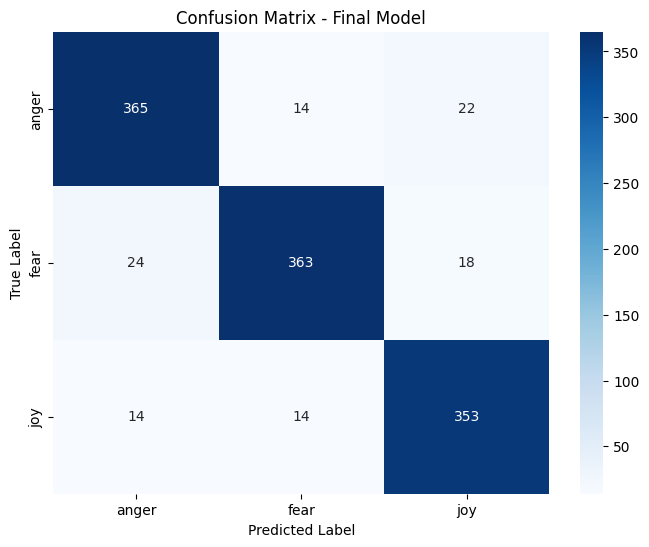

In [78]:
print("\nRetraining Model 2 for 8 epochs for prediction:")
model2 = Sequential()
model2.add(embedding_layer2)
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['acc'])
model2.summary()
history_final = model2.fit(X_train, y_train,
                          epochs=8,
                          batch_size=32,
                          validation_split=0.2)
y_pred_prob = model2.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nEvaluation of the final Model (Model 2 after 5 epochs):")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Final Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Con dei buoni valori per accuracy, recall e f1 score, il modello due è il più consono alla situazione poichè riesce ad avere una buona accuracy nonostante un leggero seppur stabile, overfitting.

### Ulteriore tuning, aggiunta di layer convolutivo ed early stopping per prevenire ulteriormente overfitting.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3622 - loss: 1.0967 - val_accuracy: 0.6280 - val_loss: 1.0431
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8040 - loss: 0.8184 - val_accuracy: 0.9252 - val_loss: 0.2121
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9370 - loss: 0.1718 - val_accuracy: 0.9336 - val_loss: 0.1730
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9644 - loss: 0.1041 - val_accuracy: 0.9399 - val_loss: 0.1675
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9779 - loss: 0.0713 - val_accuracy: 0.9431 - val_loss: 0.1640
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9850 - loss: 0.0535 - val_accuracy: 0.9368 - val_loss: 0.1755
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9895 - loss: 0.0401 - val_accuracy: 0.9399 - val_loss: 0.1799
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9942 - loss: 0.0288 - val_accu

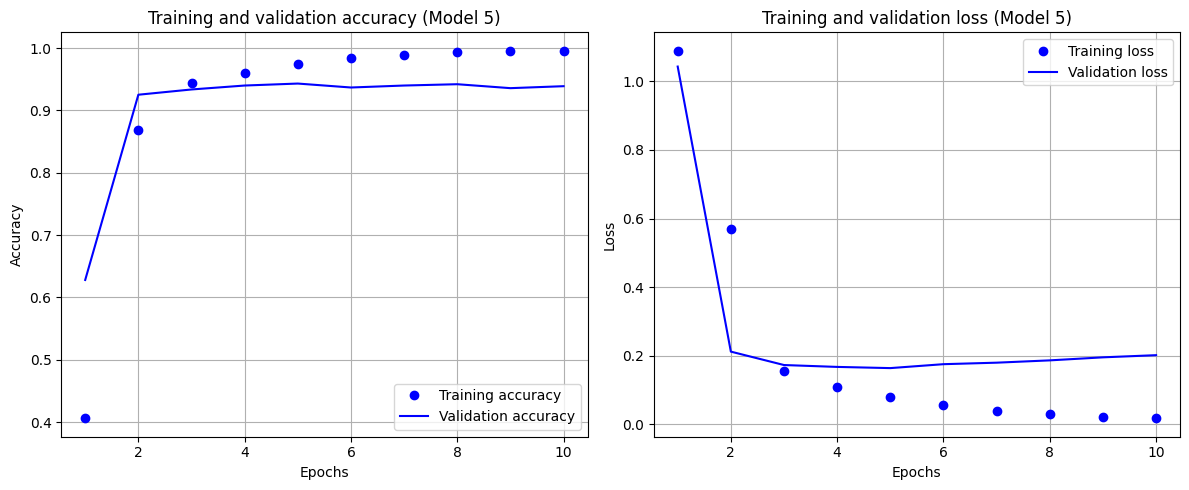

In [80]:
embedding_layer2 = Embedding(10000, 16, input_length=maxlen) # Ensure input_length is set
model5 = Sequential()
model5.add(embedding_layer2)
model5.add(layers.Conv1D(128, 5, activation='relu'))
model5.add(layers.GlobalMaxPooling1D())
model5.add(Dense(3, activation='softmax'))
model5.compile(optimizer=Adam(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model5.summary()
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True # Restore weights from the best epoch
)
history5 = model5.fit(X_train, y_train,
                    epochs=50, # Train for potentially more epochs, early stopping will handle it
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

acc5 = history5.history['accuracy']
val_acc5 = history5.history['val_accuracy']
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']
epochs5 = range(1, len(acc5) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs5, acc5, 'bo', label='Training accuracy')
plt.plot(epochs5, val_acc5, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 5)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs5, loss5, 'bo', label='Training loss')
plt.plot(epochs5, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

Effettivamente l'overfitting del modello viene notevolmente ridotto, inserendo uno strato convolutivo, vengono utilizzati meno parametri ed estratte le features locali importanti. Questo genera una notevole diminuizione della complessità nell'apprendimento del nostro modello.

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7135 - loss: 0.8469 - val_accuracy: 0.9336 - val_loss: 0.2151
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9601 - loss: 0.1353 - val_accuracy: 0.9442 - val_loss: 0.1503
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9714 - loss: 0.0817 - val_accuracy: 0.9420 - val_loss: 0.1428
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9813 - loss: 0.0597 - val_accuracy: 0.9399 - val_loss: 0.1477
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9890 - loss: 0.0450 - val_accuracy: 0.9452 - val_loss: 0.1550
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9954 - loss: 0.0282 - val_accuracy: 0.9389 - val_loss: 0.1608
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9950 - loss: 0.0244 - val_accuracy: 0.9420 - val_loss: 0.1661
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9964 - loss: 0.0194 - val_accu

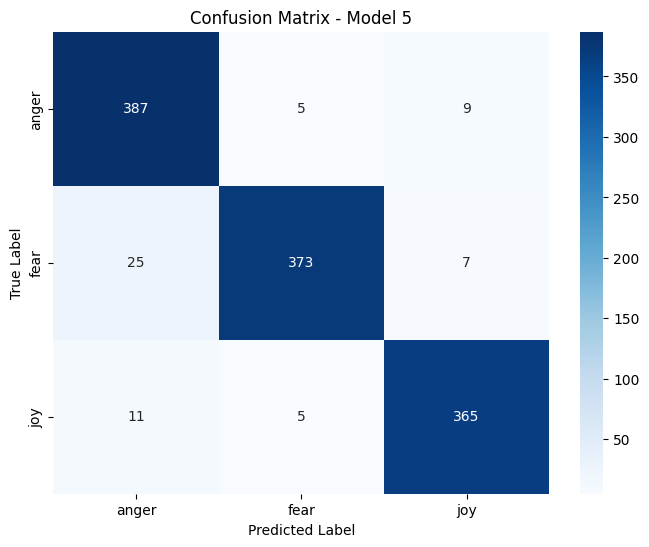

In [81]:
model5 = Sequential()
model5.add(embedding_layer2)
model5.add(layers.Conv1D(128, 5, activation='relu'))
model5.add(layers.GlobalMaxPooling1D())
model5.add(Dense(3, activation='softmax'))
model5.compile(optimizer=Adam(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model5.summary()
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True # Restore weights from the best epoch
)
history5 = model5.fit(X_train, y_train,
                    epochs=50, # Train for potentially more epochs, early stopping will handle it
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])
y_pred_prob5 = model5.predict(X_test)
y_pred5 = np.argmax(y_pred_prob5, axis=1)
y_true5 = np.argmax(y_test, axis=1)
print("\nEvaluation of Model 5:")
print(classification_report(y_true5, y_pred5, target_names=label_encoder.classes_))
cm5 = confusion_matrix(y_true5, y_pred5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Model 5')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Come possiamo osservare dal report, l'ulteriore modifica dell'architettura del modello permette di raggiungere un elevato valore di accuracy, rendendo il modello efficace nelle classificazioni.